### imports

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

In [2]:
%matplotlib widget    

In [3]:
# set option to show plot of save as pdf or pgf -> set to either 'pdf' or 'pgf' for LaTeX
save_fig = False

# directory to save plots to 
directory_save = '../logs/evaluations/'

# set height and width of figure
figure_width = 8
figure_height = 12

In [4]:
if save_fig:    
    mpl.use(save_fig)
    plt.rcParams.update({   "font.family": "serif", # serif/main font for text
                            "text.usetex": True,    # inline math for ticks
                            "pgf.rcfonts": False})  # fonts not from rc parameters

In [5]:
directorys = ['3', '10', '42', '100', '123']
num_seeds = len(directorys)

### data

In [6]:
def get_data(eval_data_traffic_rule):

    eval_dir = '../logs/evaluations/'

    # data dicts
    ADE_data_right = {}
    ADE_data_left = {}
    ADE_data_straight = {}
    ADE_data_misc = {}
    ADE_data_all = {}

    
    for directory in directorys:

        eval_dir = '../logs/evaluations/' + directory + '/'+eval_data_traffic_rule+'/'

        for file_name in os.listdir(eval_dir):
            if os.path.isfile(eval_dir+file_name):

                # model and dataset name
                model_name = file_name.split('-')[2]
                dataset_name = file_name.split('-')[5]
                traffic_rule = file_name.split('-')[-2]

                # percent used for training
                percent = file_name.split('-')[-1][:-4]
                if dataset_name == 'nuscenes' and percent != '100.0':   percent = round(float(percent) * 128/195)
                else:                                                   percent = round(float(percent))

                # determine if base model or finetuned
                finetuned = 'finetuned' if 'finetuned' in file_name else 'base'

                # get ades
                ADEs = np.load(eval_dir+file_name).reshape(5,-1)[1,:] # right, left, straight, misc, all
                ADE_right, ADE_left, ADE_straight, ADE_misc, ADE_all = ADEs

                # make key
                key = finetuned+'-'+traffic_rule+'-'+dataset_name+'-'+model_name+'-'+f'{percent}'

                # save data
                ADE_data_right[key] = ADE_right if key not in ADE_data_right else np.concatenate((np.array(ADE_data_right[key]).reshape(-1), [ADE_right]))
                ADE_data_left[key] = ADE_left if key not in ADE_data_left else np.concatenate((np.array(ADE_data_left[key]).reshape(-1), [ADE_left]))
                ADE_data_straight[key] = ADE_straight if key not in ADE_data_straight else np.concatenate((np.array(ADE_data_straight[key]).reshape(-1), [ADE_straight]))
                ADE_data_misc[key] = ADE_misc if key not in ADE_data_misc else np.concatenate((np.array(ADE_data_misc[key]).reshape(-1), [ADE_misc]))
                ADE_data_all[key] = ADE_all if key not in ADE_data_all else np.concatenate((np.array(ADE_data_all[key]).reshape(-1), [ADE_all]))

    return  ADE_data_right, ADE_data_left, ADE_data_straight, ADE_data_misc, ADE_data_all

### plot

In [7]:
def make_plot(ax, loaded_data):
    
    # data arrays
    x_LSTM_nuscenes, data_LSTM_nuscenes = [],[]
    x_VectorNet_nuscenes, data_VectorNet_nuscenes = [],[]
    x_LSTM_argoverse, data_LSTM_argoverse = [],[]
    x_VectorNet_argoverse, data_VectorNet_argoverse = [],[]

    for data_key in loaded_data:

        # get data
        data = loaded_data[data_key]
        percent = float(data_key.split('-')[-1])

        # check if not base model
        if 'base' in data_key:
            if 'right' in data_key: percent = 0
            elif 'left' in data_key: percent = 100

        # collect data
        if 'argoverse' in data_key and 'VectorNet' in data_key: 
            x_VectorNet_argoverse.append(percent)
            data_VectorNet_argoverse.append(data)
        elif 'argoverse' in data_key and 'LSTM' in data_key: 
            x_LSTM_argoverse.append(percent)
            data_LSTM_argoverse.append(data)
        elif 'nuscenes' in data_key and 'VectorNet' in data_key: 
            x_VectorNet_nuscenes.append(percent)
            data_VectorNet_nuscenes.append(data)
        elif 'nuscenes' in data_key and 'LSTM' in data_key: 
            x_LSTM_nuscenes.append(percent)
            data_LSTM_nuscenes.append(data)

    # sort all data and reshape a bit
    data_VectorNet_argoverse = np.array(data_VectorNet_argoverse).reshape(-1)[np.argsort(np.array(x_VectorNet_argoverse).repeat(num_seeds))].reshape(-1,num_seeds)
    x_VectorNet_argoverse = np.sort(x_VectorNet_argoverse)

    data_LSTM_argoverse = np.array(data_LSTM_argoverse).reshape(-1)[np.argsort(np.array(x_LSTM_argoverse).repeat(num_seeds))].reshape(-1,num_seeds)
    x_LSTM_argoverse = np.sort(x_LSTM_argoverse)

    data_VectorNet_nuscenes = np.array(data_VectorNet_nuscenes).reshape(-1)[np.argsort(np.array(x_VectorNet_nuscenes).repeat(num_seeds))].reshape(-1,num_seeds)
    x_VectorNet_nuscenes = np.sort(x_VectorNet_nuscenes)

    data_LSTM_nuscenes = np.array(data_LSTM_nuscenes).reshape(-1)[np.argsort(np.array(x_LSTM_nuscenes).repeat(num_seeds))].reshape(-1,num_seeds)
    x_LSTM_nuscenes = np.sort(x_LSTM_nuscenes)

    # plotting
    err = ax.errorbar(x_VectorNet_argoverse, np.mean(data_VectorNet_argoverse, axis=1), yerr=np.std(data_VectorNet_argoverse, axis=1), capsize=6, alpha=.8, ls='-')
    err[-1][0].set_alpha(.3)

    err = ax.errorbar(x_LSTM_argoverse, np.mean(data_LSTM_argoverse, axis=1), yerr=np.std(data_LSTM_argoverse, axis=1), capsize=6, alpha=.8, ls='--')
    err[-1][0].set_alpha(.3)

    err = ax.errorbar(x_VectorNet_nuscenes, np.mean(data_VectorNet_nuscenes, axis=1), yerr=np.std(data_VectorNet_nuscenes, axis=1), capsize=6, alpha=.8, ls='-')
    err[-1][0].set_alpha(.3)

    err = ax.errorbar(x_LSTM_nuscenes, np.mean(data_LSTM_nuscenes, axis=1), yerr=np.std(data_LSTM_nuscenes, axis=1), capsize=6, alpha=.8, ls='--')
    err[-1][0].set_alpha(.3)

    ax.ylim([1, 3.3])

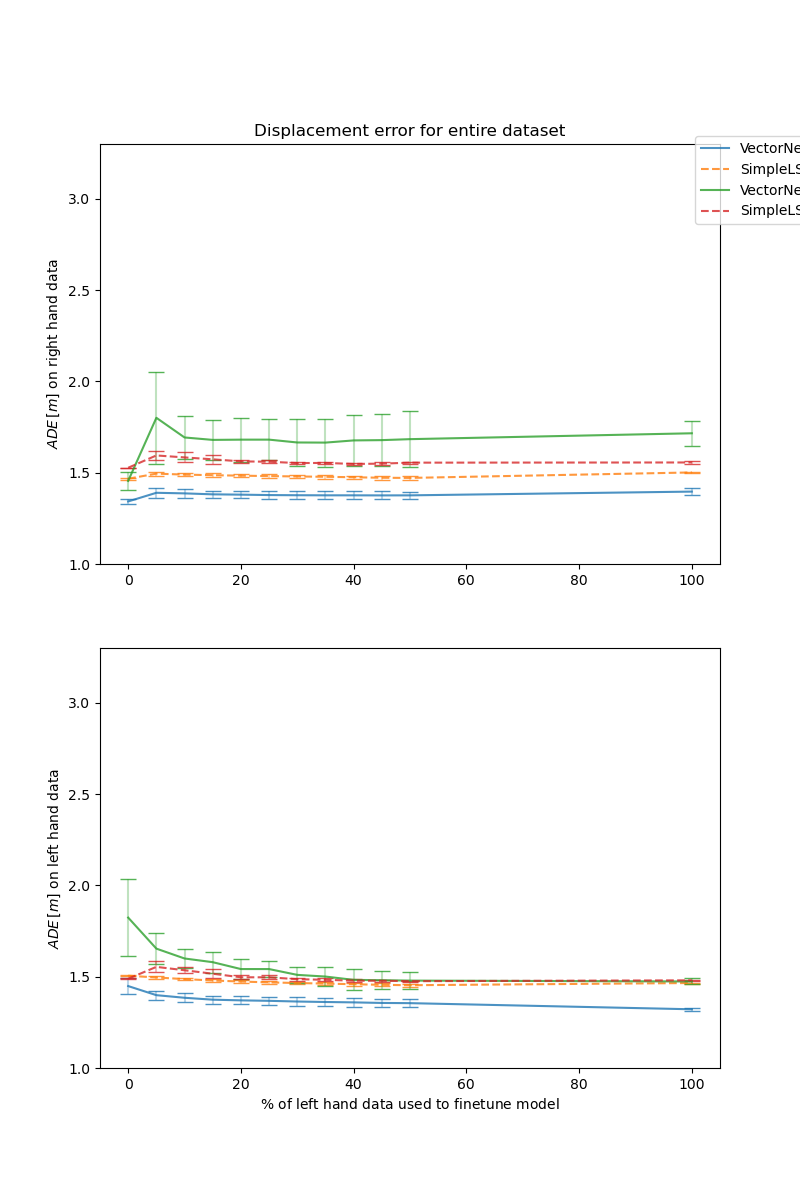

In [8]:
# create figure
fig = plt.figure()
fig.set_size_inches(w=figure_width, h=figure_height)

ADE_data_right, ADE_data_left, ADE_data_straight, ADE_data_misc, ADE_data_all = get_data('right')
plt.subplot(2, 1, 1)
make_plot(plt, ADE_data_all)
plt.ylabel('$ADE\,[m]$ on right hand data')
plt.title('Displacement error for entire dataset')

ADE_data_right, ADE_data_left, ADE_data_straight, ADE_data_misc, ADE_data_all = get_data('left')
plt.subplot(2, 1, 2)
make_plot(plt, ADE_data_all)
plt.ylabel('$ADE\,[m]$ on left hand data')
plt.xlabel("$\%$ of left hand data used to finetune model")

# Creating legend for figure
custom_lines = [Line2D([0], [0], linestyle='-', color='C0', alpha=.8),
                Line2D([0], [0], linestyle='--', color='C1', alpha=.8),
                Line2D([0], [0], linestyle='-', color='C2', alpha=.8),
                Line2D([0], [0], linestyle='--', color='C3', alpha=.8)]

fig.legend(custom_lines, ['VectorNet/Argovesre', 'SimpleLSTM/Argovesre', 'VectorNet/NuScenes','SimpleLSTM/NuScenes'], bbox_to_anchor=[1, 0.85], loc='center')

if save_fig:    plt.savefig(directory_save+f'plots/ADE_all.{save_fig}', bbox_inches="tight")
else:           plt.show()


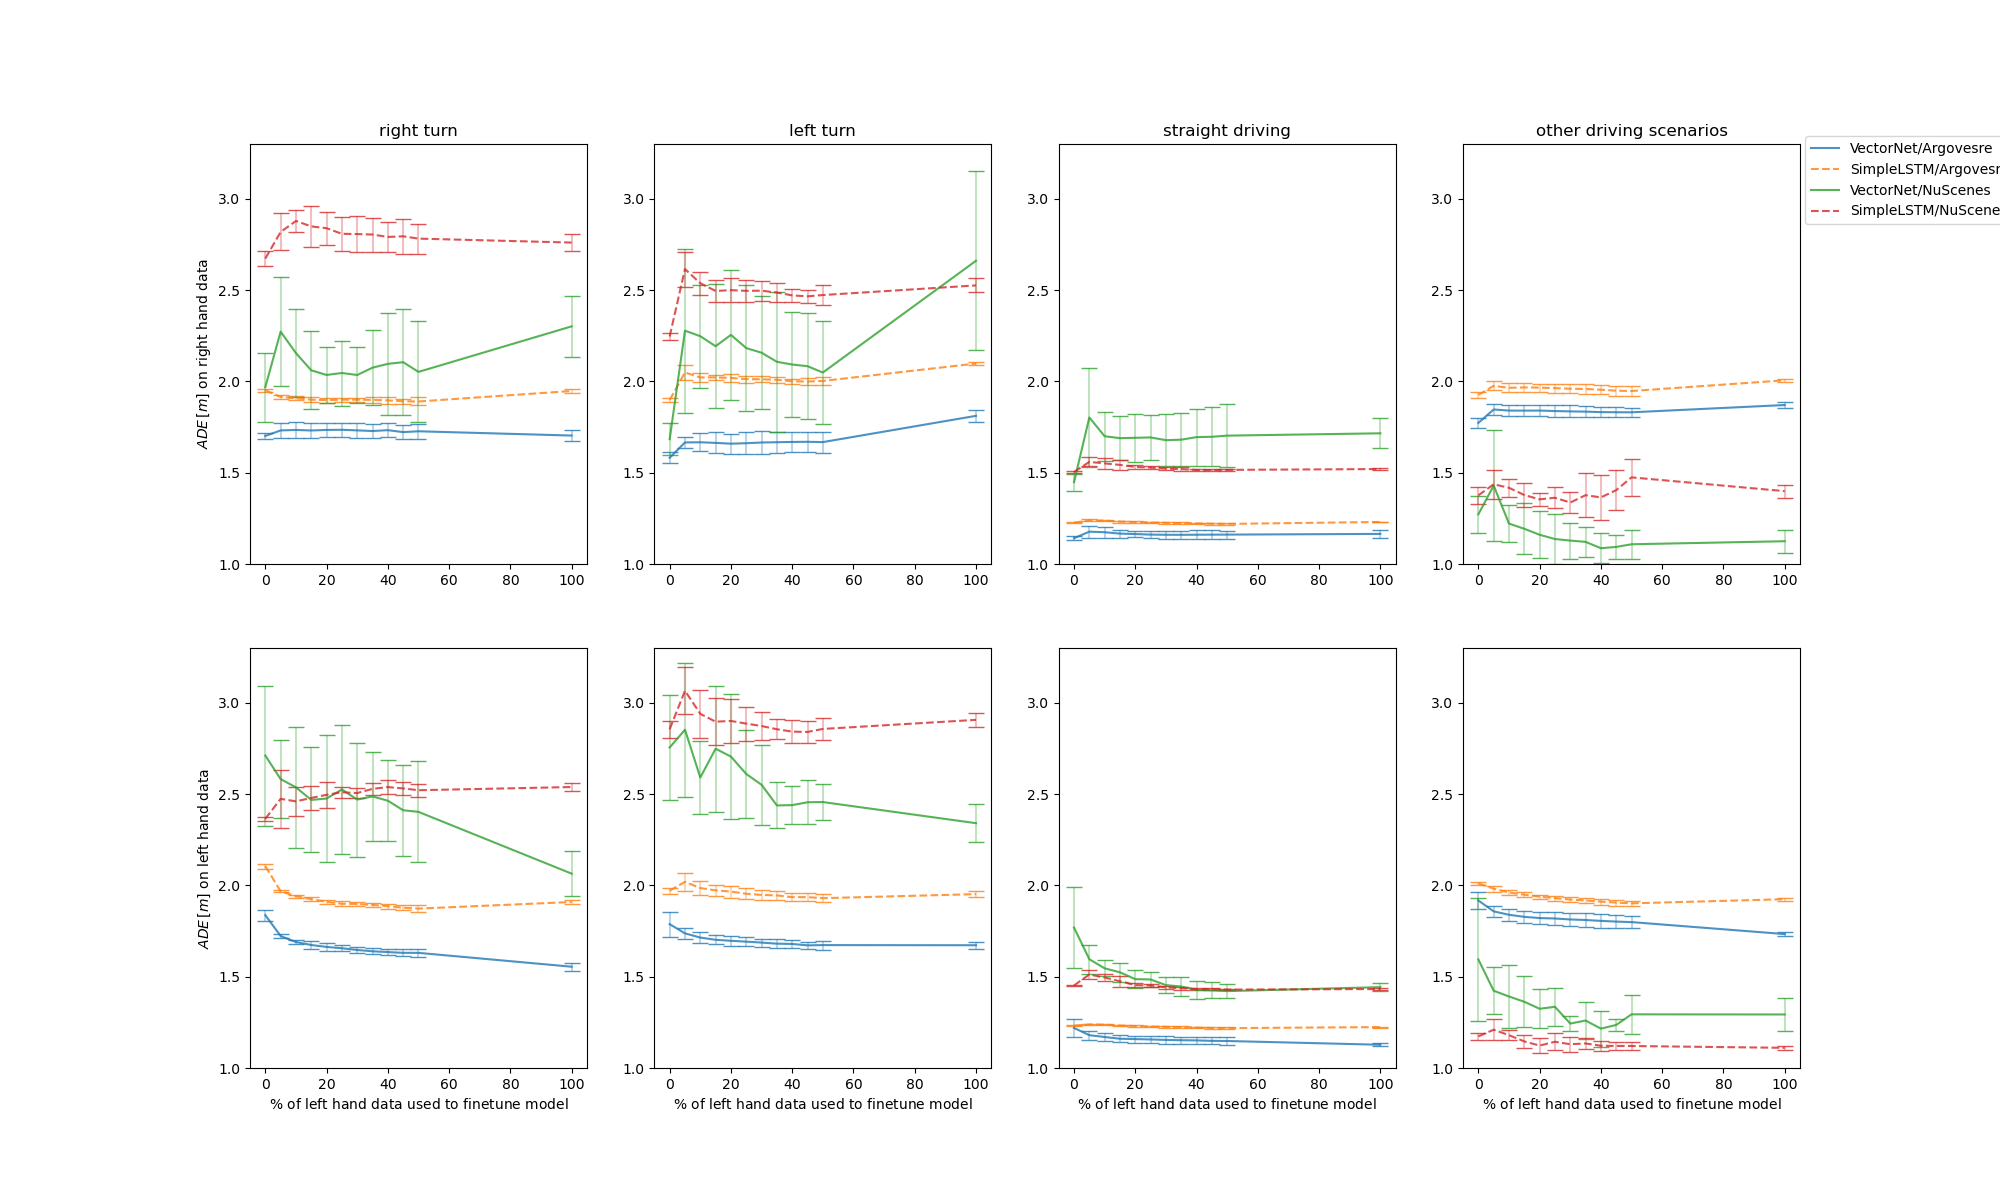

In [9]:
# create figure
fig = plt.figure()
fig.set_size_inches(w=figure_width*2.5, h=figure_height)

ADE_data_right, ADE_data_left, ADE_data_straight, ADE_data_misc, ADE_data_all = get_data('right')
plt.subplot(2, 4, 1)
make_plot(plt, ADE_data_right)
plt.ylabel('$ADE\,[m]$ on right hand data')
plt.title('right turn')

plt.subplot(2, 4, 2)
make_plot(plt, ADE_data_left)
plt.title('left turn')

plt.subplot(2, 4, 3)
make_plot(plt, ADE_data_straight)
plt.title('straight driving')

plt.subplot(2, 4, 4)
make_plot(plt, ADE_data_misc)
plt.title('other driving scenarios')

ADE_data_right, ADE_data_left, ADE_data_straight, ADE_data_misc, ADE_data_all = get_data('left')
plt.subplot(2, 4, 5)
make_plot(plt, ADE_data_right)
plt.ylabel('$ADE\,[m]$ on left hand data')
plt.xlabel("$\%$ of left hand data used to finetune model")

plt.subplot(2, 4, 6)
make_plot(plt, ADE_data_left)
plt.xlabel("$\%$ of left hand data used to finetune model")

plt.subplot(2, 4, 7)
make_plot(plt, ADE_data_straight)
plt.xlabel("$\%$ of left hand data used to finetune model")

plt.subplot(2, 4, 8)
make_plot(plt, ADE_data_misc)
plt.xlabel("$\%$ of left hand data used to finetune model")


# Creating legend for figure
custom_lines = [Line2D([0], [0], linestyle='-', color='C0', alpha=.8),
                Line2D([0], [0], linestyle='--', color='C1', alpha=.8),
                Line2D([0], [0], linestyle='-', color='C2', alpha=.8),
                Line2D([0], [0], linestyle='--', color='C3', alpha=.8)]

fig.legend(custom_lines, ['VectorNet/Argovesre', 'SimpleLSTM/Argovesre', 'VectorNet/NuScenes','SimpleLSTM/NuScenes'], bbox_to_anchor=[0.955, 0.85], loc='center')

if save_fig:    plt.savefig(directory_save+f'plots/ADE_by_direction.{save_fig}', bbox_inches="tight")
else:           plt.show()
